In [1]:
# --- Cell 1: Imports & config ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Matplotlib defaults (simple, readable)
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

# >>> Set this to your local CSV location <<<
DATA_DIR = Path("data")  # change if needed

# File used for Sujit's dataset (a.k.a. your "dest_data_moca")
TRAJ_FILE = DATA_DIR / "test_data_moca.csv"  # ensure this exists locally

# MoCA scores to select
TARGET_MOCA = [26, 28, 30]


In [2]:
# --- Cell 2: Load data & basic sanity checks ---
df = pd.read_csv(TRAJ_FILE)

expected_cols = {"pid", "blockno", "coordt", "speed", "pausevalue", "moca"}
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected column(s): {missing}. Found columns: {df.columns.tolist()}")

# Ensure types
df["blockno"] = pd.to_numeric(df["blockno"], errors="coerce").astype("Int64")
df["moca"]    = pd.to_numeric(df["moca"], errors="coerce").astype("Int64")
df["coordt"]  = pd.to_numeric(df["coordt"], errors="coerce")
df["speed"]   = pd.to_numeric(df["speed"], errors="coerce")
df["pausevalue"] = pd.to_numeric(df["pausevalue"], errors="coerce")

# Drop rows with key nulls
df = df.dropna(subset=["pid", "blockno", "coordt"])

# Optional: keep only “main task” blocks if there are extra blocks labeled weirdly
# Here we keep blocks that appear for most pids (robust heuristic)
block_counts = df.groupby("blockno")["pid"].nunique().sort_index()
common_blocks = block_counts[block_counts >= block_counts.median()].index
df = df[df["blockno"].isin(common_blocks)]


In [3]:
# --- Cell 3: Normalize time to seconds & compute per-sample dt ---
# Some recordings store coordt in milliseconds. Infer unit by looking at typical diffs.
# If median Δt > 1 and < 50, we treat coordt as milliseconds; else assume seconds.

df = df.sort_values(["pid", "blockno", "coordt"]).copy()

# quick sample of deltas to guess units
sample = (
    df.groupby(["pid", "blockno"])["coordt"]
      .apply(lambda s: s.diff().dropna().median())
      .dropna()
)
median_dt = sample.median() if not sample.empty else np.nan

# Convert to seconds if it looks like ms (between ~2 and ~100 ms)
if pd.notna(median_dt) and 1 < median_dt < 100:
    time_scale = 1_000.0  # ms -> s
else:
    time_scale = 1.0      # already seconds

df["time_s"] = df["coordt"] / time_scale

# Per-sample dt within (pid, block)
df["dt"] = df.groupby(["pid", "blockno"])["time_s"].diff()
# Clean weird/negative or missing dt
df["dt"] = df["dt"].where(df["dt"] > 0, np.nan)


In [4]:
# --- Cell 4: Pick representative participants for each target MoCA ---
# Strategy: from all pids with that MoCA, pick the one with the most samples (or most blocks).
picked = {}

for score in TARGET_MOCA:
    pool = df[df["moca"] == score]
    if pool.empty:
        print(f"WARNING: No participants found with MoCA={score}. Skipping.")
        continue

    # Rank pids by (#blocks, #rows) to prefer more complete recordings
    by_pid = (
        pool.groupby("pid")
            .agg(n_blocks=("blockno", "nunique"), n_rows=("pid", "size"))
            .sort_values(["n_blocks", "n_rows"], ascending=False)
    )
    pid_choice = by_pid.index[0]
    picked[score] = pid_choice

picked


{26: np.int64(46), 28: np.int64(39), 30: np.int64(45)}

In [5]:
# --- Cell 5: Compute per-block metrics ---

# 1) Total pause time per block:
# Assumption: pausevalue > 0 indicates a paused sample; sum dt over those samples.
pause_df = (
    df.assign(paused=lambda x: x["pausevalue"] > 0)
      .groupby(["pid", "blockno"])
      .apply(lambda g: np.nansum(g.loc[g["paused"], "dt"]))
      .rename("pause_time_s")
      .reset_index()
)

# 2) Completion time per block: max(time_s) - min(time_s)
comp_df = (
    df.groupby(["pid", "blockno"])["time_s"]
      .agg(lambda s: s.max() - s.min())
      .rename("completion_time_s")
      .reset_index()
)

# 3) Median speed per block (units as given by `speed`)
medspeed_df = (
    df.groupby(["pid", "blockno"])["speed"]
      .median()
      .rename("median_speed")
      .reset_index()
)

# Merge metrics
blk = pause_df.merge(comp_df, on=["pid", "blockno"], how="outer") \
              .merge(medspeed_df, on=["pid", "blockno"], how="outer")

# Restrict to common blocks across selected participants to keep x-axes aligned nicely
if picked:
    sel_pids = list(picked.values())
    common_blk = (
        blk[blk["pid"].isin(sel_pids)]
        .groupby("blockno")["pid"].nunique()
    )
    good_blocks = common_blk[common_blk == len(sel_pids)].index
    blk_sel = blk[blk["blockno"].isin(good_blocks)].copy()
else:
    blk_sel = blk.copy()

# For convenience, add MoCA to block-level frame (using per-pid lookup)
pid_moca = df.groupby("pid")["moca"].agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0])
blk_sel["moca"] = blk_sel["pid"].map(pid_moca)


/tmp/ipykernel_42820/3310899379.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.nansum(g.loc[g["paused"], "dt"]))


In [6]:
# --- Cell 6: Assemble plotting frames ---
def make_plot_frame(metric_col: str):
    # 3 participants (MoCA 26, 28, 30) — one line each
    lines = []
    legend = []

    for score in TARGET_MOCA:
        pid_choice = picked.get(score)
        if pid_choice is None:
            continue
        sub = blk_sel[blk_sel["pid"] == pid_choice][["blockno", metric_col]].dropna()
        sub = sub.sort_values("blockno")
        sub = sub.set_index("blockno")[metric_col]
        lines.append(sub)
        legend.append(f"PID {pid_choice} (MoCA {score})")

    # Group mean & median at each block across ALL participants in Sujit's data
    group = blk_sel[["blockno", metric_col]].dropna()
    group_mean = group.groupby("blockno")[metric_col].mean().sort_index()
    group_median = group.groupby("blockno")[metric_col].median().sort_index()

    lines.append(group_mean)
    legend.append("Group Mean")
    lines.append(group_median)
    legend.append("Group Median")

    # Align on union of block indices
    frame = pd.concat(lines, axis=1)
    frame.columns = legend
    return frame

pause_frame  = make_plot_frame("pause_time_s")
comp_frame   = make_plot_frame("completion_time_s")
speed_frame  = make_plot_frame("median_speed")

pause_frame.head(), comp_frame.head(), speed_frame.head()


(         PID 46 (MoCA 26)  PID 39 (MoCA 28)  PID 45 (MoCA 30)  Group Mean  \
 blockno                                                                     
 1                  32.906            18.498            22.759   18.282273   
 2                  28.758            18.292            16.623   16.178091   
 3                  30.991            17.839            15.380   15.343273   
 4                  36.441            13.644            12.458   14.687818   
 5                  23.493            17.334            12.010   13.756091   
 
          Group Median  
 blockno                
 1              17.407  
 2              13.743  
 3              13.260  
 4              12.277  
 5              11.743  ,
          PID 46 (MoCA 26)  PID 39 (MoCA 28)  PID 45 (MoCA 30)  Group Mean  \
 blockno                                                                     
 1                  38.727            18.498            22.759   22.446364   
 2                  28.758            18.2

In [7]:
# --- Cell 7: Plotting helper ---
def plot_metric(frame: pd.DataFrame, title: str, y_label: str):
    fig, ax = plt.subplots()
    # Plot each column as its own line
    for col in frame.columns:
        ax.plot(frame.index, frame[col], marker="o", label=col)
    ax.set_title(title)
    ax.set_xlabel("Block")
    ax.set_ylabel(y_label)
    ax.legend()
    plt.show()


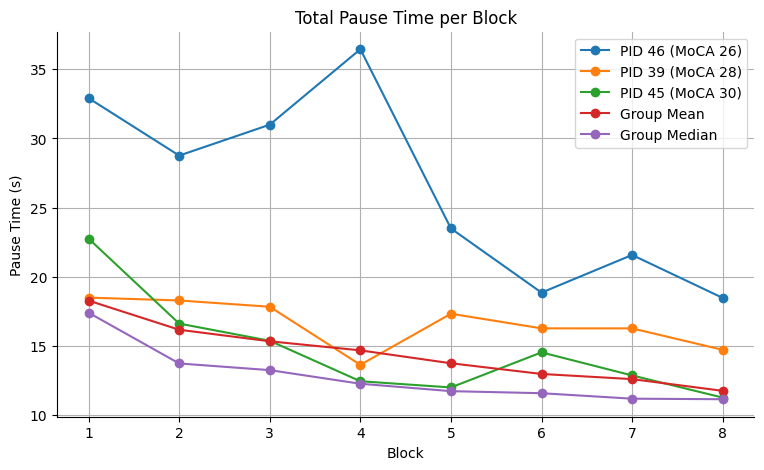

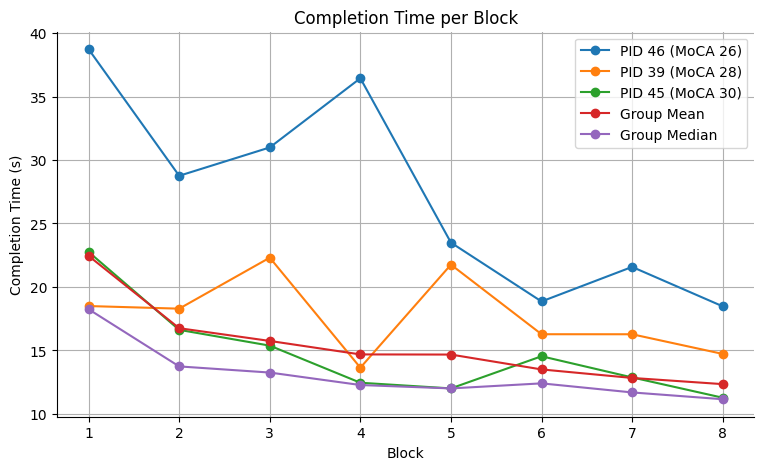

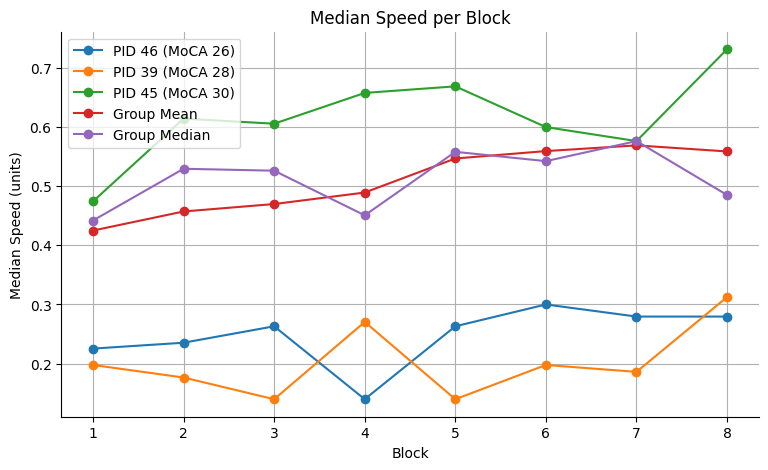

In [9]:
# --- Cell 8: Render the three requested figures ---

# 1) Total pause time per block (seconds)
plot_metric(pause_frame, "Total Pause Time per Block", "Pause Time (s)")

# 2) Completion time per block (seconds)
plot_metric(comp_frame, "Completion Time per Block", "Completion Time (s)")

# 3) Median speed per block
plot_metric(speed_frame, "Median Speed per Block", "Median Speed (units)")
